# Question 1: Predicting air quality measurements near methane emitter sources

##### **To use as a feature for prediction questions 2 & 3**
We'd like to use air quality as a feature in our model; however, we don't have air quality measurements at the exact location of our emitter points. Therefore, we'll use a K Nearest Neighbors model to predict the monthly average air quality at our emitter points, and use these predictions as a feature for our other prediction questions. 

In [88]:
#Import modules
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns

#### Prepare data for model

First, we'll load in and take a look at our air quality data and the rest of our features/response. 

In [38]:
#Load data
airnow = gpd.read_file('Data/airnow_monthly_averages.json/airnow_monthly_averages.shp')
ch4 = gpd.read_file('Data/target_and_features.geojson')

In [28]:
#Check data
airnow.head()

,Latitude,Longitude,Parameter,Unit,Category,SiteName,AgencyName,FullAQSCod,IntlAQSCod,year,month,Value_mean,Value_coun,RawConcent,RawConce_1,AQI_mean,AQI_count,geometry
0,32.7355,-116.3454,PM10,UG/M3,0,Manzanita Tribe 1,Manzanita Band of the Kumeyaay Nation,60732000,840060732000,2016,1,-0.1500000000,2,0.0000000000,2,NaN,0,POINT (-116.34540 32.73550)
1,32.7355,-116.3454,PM10,UG/M3,1,Manzanita Tribe 1,Manzanita Band of the Kumeyaay Nation,60732000,840060732000,2016,1,2.9335149864,734,2.9221311475,732,2.7506811989,734,POINT (-116.34540 32.73550)
2,32.7355,-116.3454,PM10,UG/M3,1,Manzanita Tribe 1,Manzanita Band of the Kumeyaay Nation,60732000,840060732000,2016,2,5.7252906977,3440,5.8673469388,3430,5.3066860465,3440,POINT (-116.34540 32.73550)
3,32.7355,-116.3454,PM10,UG/M3,1,Manzanita Tribe 1,Manzanita Band of the Kumeyaay Nation,60732000,840060732000,2016,3,7.5774456522,2944,7.5869565217,2944,7.0095108696,2944,POINT (-116.34540 32.73550)
4,32.7355,-116.3454,PM10,UG/M3,1,Manzanita Tribe 1,Manzanita Band of the Kumeyaay Nation,60732000,840060732000,2016,4,11.3661991585,2139,11.4044943820,2136,10.5315568022,2139,POINT (-116.34540 32.73550)


In [29]:
airnow.shape

(17348, 18)

In [30]:
#Check data
ch4.head()

,Vista_ID,AVIRIS_CH4_median_ppmm,AVIRIS_CH4_median_date,AVIRIS_CH4_pxcount,CH4_Mass_kg,ng_pipelength_2,ng_pipelength_1000,ng_pipelength_5000,ng_pipelength_10000,ng_pipelength_50000,...,EmitterType_Refinery,EmitterType_Wastewater.Treatment.Plant,NearestNeighbor,NN_Distance_m,NN_Type,aviris_month,tropomi_no2_mean,tropomi_o3_mean,tropomi_so2_mean,geometry
0,DAF001852,152.0039,2016-09-11,835.7500,0.0001,6392.1007,7391.6466,16539.2553,57707.9384,667538.8408,...,0,0,DAF000658,2466.0455,Dairy,9,0.0,2.7501,0.3199,"MULTIPOLYGON (((-82488.739 -16790.579, -82489...."
1,DAF001876,111.8814,2016-09-12,1670.0000,0.0001,85884.6586,94127.2287,127492.1839,170899.8068,842878.1810,...,0,0,COM000219,781.9825,Natural Gas Station,9,0.0,2.7094,0.4187,"MULTIPOLYGON (((260247.391 -342212.585, 260246..."
2,DAF001759,244.1223,2016-09-12,3346.0000,0.0002,18873.8279,21161.2918,29954.3051,43939.1783,334243.8826,...,0,0,DAF000910,4638.2693,Dairy,9,0.0,2.6972,0.3413,"MULTIPOLYGON (((61647.033 -234595.348, 61646.1..."
3,DAF001767,112.7884,2016-09-12,1114.6667,0.0001,0.0000,0.0000,0.0000,6753.5702,336951.9840,...,0,0,OGW166989,1181.9761,Oil and Gas Well,9,0.0,2.6981,0.3361,"MULTIPOLYGON (((45304.763 -224578.476, 45303.9..."
4,DAF001776,105.4107,2016-09-12,1216.2727,0.0001,0.0000,0.0000,0.0000,0.0000,264800.5901,...,0,0,FDL000024,1901.1757,Feed Lot,9,0.0,2.7004,0.3429,"MULTIPOLYGON (((39551.942 -203816.734, 39551.1..."


In [31]:
ch4.shape

(48386, 65)

As we saw in our EDA of our AirNow data, we have the fewest monitors for SO2 and CO. This might lead to inaccurate predictions for these two parameters, since we have so few data to train on, and since our emitters will likely be located quite far from these few monitor locations. 

We can take a closer look to see what this will mean with regard to the number of observations for each of these parameters. 

In [32]:
#Let's see how many observations there are for each parameter
print(airnow[airnow['Parameter'] == 'PM2.5'].shape)
print(airnow[airnow['Parameter'] == 'PM10'].shape)
print(airnow[airnow['Parameter'] == 'OZONE'].shape)
print(airnow[airnow['Parameter'] == 'CO'].shape)
print(airnow[airnow['Parameter'] == 'NO2'].shape)
print(airnow[airnow['Parameter'] == 'SO2'].shape)

(4944, 18)
(2504, 18)
(7008, 18)
(952, 18)
(1550, 18)
(390, 18)


In [33]:
#Let's see how many measurements there for one year and month
print(airnow[(airnow['Parameter'] == 'CO') & (airnow['month'] == 10) & (airnow['year'] == 2016)].shape)
print(airnow[(airnow['Parameter'] == 'SO2') & (airnow['month'] == 10) & (airnow['year'] == 2016)].shape)
print(airnow[(airnow['Parameter'] == 'PM2.5') & (airnow['month'] == 10) & (airnow['year'] == 2016)].shape)
print(airnow[(airnow['Parameter'] == 'PM10') & (airnow['month'] == 10) & (airnow['year'] == 2016)].shape)
print(airnow[(airnow['Parameter'] == 'NO2') & (airnow['month'] == 10) & (airnow['year'] == 2016)].shape)
print(airnow[(airnow['Parameter'] == 'OZONE') & (airnow['month'] == 10) & (airnow['year'] == 2016)].shape)

(26, 18)
(13, 18)
(161, 18)
(107, 18)
(45, 18)
(316, 18)


For a given month/year, we only have 13 observations for SO2 and 26 observations for CO. As such, our predictions for these two parameters could end up being quite meaningless, as they will likely be averaging measures that were taken from hundreds of miles away from each other. We'll drop these two parameters and focus on the other four for our KNN model. 

Next, we'll want to make sure that our datasets are in the same CRS. 

In [36]:
airnow.crs

{'init': 'epsg:4326'}

In [39]:
ch4.crs

{'init': 'epsg:4326'}

Our emitter data is showing the the CRS is WGS84, but we know this is not correct by looking at the geometries. We'll have to manually reset the CRS, which we know is in CA Albers from our other data cleaning. 

In [40]:
#Note: gpd is reading the incorrect CRS. Reset to CA Albers, NAD1983 meters
ch4.crs = {'init': 'epsg:3310'}

A projected CRS is preferred when calculating distances. We'll reproject our AirNow data to CA ALbers. 

In [41]:
#Since our CH4 emitter points are in the CA Albers projection, we'll need to change the CRS of our airnow dataframe
airnow = airnow.to_crs(epsg=3310)

/Users/michellesims/opt/anaconda3/envs/pp275/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


We can make sure that our two datasets line up by plotting the data. 

<AxesSubplot:>

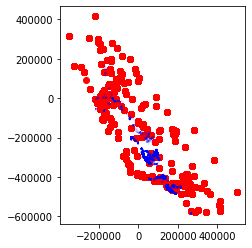

In [47]:
fig, ax = plt.subplots()
airnow.plot(ax = ax, color = 'red')
ch4.boundary.plot(ax = ax, color = 'blue')

The two datasets line up. 

Finally, we'll want to check the dates of our AVIRIS flights. These are the months we'll want want to use when fitting our model, since we want the AirNow monthly mean measurements to line up with the months of our AVIRIS flights. 

In [39]:
#check dates; these are the month/date combos we'll use in the predictions
ch4['AVIRIS_CH4_median_date'].unique()

array(['2016-09-11', '2016-09-12', '2016-09-13', '2016-09-14',
       '2016-09-15', '2016-09-16', '2016-09-17', '2016-09-10',
       '2016-09-22', '2016-09-25', '2016-09-30', '2016-10-01',
       '2016-09-19', '2016-10-03', '2016-10-08', '2016-10-05',
       '2016-10-06', '2016-10-11', '2016-10-25', '2016-10-29',
       '2016-11-03', '2017-03-09', '2017-06-15', '2016-10-26',
       '2017-06-16', '2016-11-04', '2016-11-02', '2017-06-18',
       '2017-06-20', '2017-08-30', '2017-08-31', '2017-09-01',
       '2017-09-05', '2017-09-06', '2017-09-07', '2017-09-08',
       '2017-09-09', '2017-09-10', '2017-09-13', '2017-09-15',
       '2017-09-16', '2017-09-11', '2017-09-20', '2017-09-26',
       '2017-09-28', '2017-06-17', '2017-10-05', '2017-09-30',
       '2017-06-19', '2017-10-06', '2017-10-07', '2017-10-10',
       '2017-09-02', '2017-10-12', '2017-10-03', '2017-10-13',
       '2017-09-18', '2017-10-16', '2017-10-23', '2017-09-19',
       '2017-10-24', '2017-09-25', '2017-09-22', '2017-

In [48]:
#Check columns
ch4.columns

Index(['Vista_ID', 'AVIRIS_CH4_median_ppmm', 'AVIRIS_CH4_median_date',
       'AVIRIS_CH4_pxcount', 'CH4_Mass_kg', 'ng_pipelength_2',
       'ng_pipelength_1000', 'ng_pipelength_5000', 'ng_pipelength_10000',
       'ng_pipelength_50000', 'weighted_cow_density', 'LULC_open_water_perc',
       'LULC_ice_snow_perc', 'LULC_developed_open_space_perc',
       'LULC_developed_low_int_perc', 'LULC_developed_med_int_perc',
       'LULC_developed_high_int_perc', 'LULC_barren_land_perc',
       'LULC_deciduous_forest_perc', 'LULC_evergreen_forest_perc',
       'LULC_mixed_forest_perc', 'LULC_shrub_scrub_perc',
       'LULC_grassland_herbaceous_perc', 'LULC_pasture_hay_perc',
       'LULC_cultivated_crops_perc', 'LULC_woody_wetlands_perc',
       'LULC_emergent_herbaceous_wetlands_perc', 'LULC_total_perc',
       'LULC_majority_class', 'LULC_Barren.Land', 'LULC_Cultivated.Crops',
       'LULC_Dev..Low.Int', 'LULC_Dev..Med.Int', 'LULC_Dev..Open.Space',
       'LULC_Evergreen.Forest', 'LULC_Grasslan

Finally, while we have a column called `aviris_month` for the month the AVIRIS flight was taken, we'll want a column for the year, as this will make it easier to subset our data for the model. 

In [68]:
#add column for aviris_year
ch4['aviris_year'] = 0

for i in range(len(ch4)):
    s = ch4['AVIRIS_CH4_median_date'][i]
    ch4.loc[i,'aviris_year']= int(s[0:4])

#### KNN Model

Because the variation in air quality measurements between locations might vary by month and year (due to wildfires and other events that might impact air quality), we'll want to subset our data by month, year, and parameter before training our model. In other words, we want to fit a model using the measurements for a given parameter, month, and year, and then use that model to predict the air quality measurement at our emitter locations for that same month and year. 

For our model, we'll use `scikitlearn`'s KNN regression, which is used for continuous data, and is computed based on the mean of the K Nearest Neighbors. Because `scikitlearn`'s KNN regression finds the nearest neighbor in **feature space**, and our goal is to find the nearest neighbor in **physical space**, we will train our model with only the lat/lon coordinates, so that the model is finding the nearest neighbor in physical space. 

The hyperparameter we'll want to test is the k value that gives us the lowest error, as measured by Root Mean Squared Error. We can us `scikitlearn`'s `GridSearchCV` to find the optimal k value for each month/year/parameter combo. Another parameter that we can test for KNN regression is `weights`: scikitlearn gives us the option to specify the weight function used in prediction; either uniform weights, or inverse distance weighting. 

Below, we'll create a function where we input the AirNow dataframe, parameter, year, month, and an array of K values, and we'll use `scikitlearn` to fit the model and return the model (which we can then use to predict the air quality measurements at the emitter location for that month, year, and parameter), the parameter specifications, and the RMSE. Note: `GridSearchCV` allows us to specify which scoring parameter we'd like to use. Since it follows the convention that higher return values are better than lower return values, MSE & RMSE are available as negated values, which is why these values will be negative. 

We'll use **Kfold cross validation with 10 folds** to test the performance of our model, following convention (note: we tried 5 folds as well, and did not see a significant change in the performance of our model). Since we are not testing between different types of models, just tuning the hyperparameters, we will not set aside a separate test set. 

For our **K values**, we'll try an array of 1-10. We will not go higher than 10, because we know based on our EDA that the AirNow monitors are not located too close to each other; therefore, if we average more than 10, we're covering a very large area of California! We want to restrain the model so that it's not averaging air quality measurements over too large a portion of the state, otherwise our prediction becomes meaningless and many of our predictions will end up taking the same value. 

In [50]:
#Define a function to train the model and find the optimal hyperparameters. 

def KNN(df, parameter, year, month, k):
    """Fits a KNN model for a specific air quality parameter, averaged over a given month, in a given year. 
    Arguments:
        dataframe: the Air Now dataframe. 
        parameter (string): Air quality measurement parameter: PM10, OZONE, PM2.5, CO, NO2, SO2
        year: year to use to fit model, 2016 or 2017
        month: month to use to fit model (1-12)
        k: an array of k values to test for fitting model
    Returns:
        model: the trained model
        opt_k: the optimal k value
        opt_score: the mean MSE of the optimal k value
        """
    
    #Filter data to month, year, and parameter
    data = df[(df['Parameter'] == parameter) & (df['year'] == year) & (df['month'] == month)]
    lat = data.geometry.y
    lon  = data.geometry.x
    X = pd.DataFrame({'lat': lat, 'lon': lon})
    y = data['Value_mean']
    
    #knn model object
    knn = KNeighborsRegressor()
    
    #create dictionary of parameter values
    param_grid = {'n_neighbors': k, 'weights': ['uniform', 'distance']}
    
    #specify hyperparameters
    knn_cv = GridSearchCV(knn, param_grid, scoring = 'neg_root_mean_squared_error', cv = 10)
    
    #fit model
    model = knn_cv.fit(X,y)
    
    return model, model.best_params_, model.best_score_
    

For our methane emitters, we have data from the following dates: Sept, Oct, and Nov 2016, & March, June, Aug, Sept, Oct, & Nov 2017. Let's fit a model and see how our KNN model performs for each of these combinations. 

In [51]:
#Set up parameters to run through the loop
parameters = ['PM10', 'OZONE', 'PM2.5', 'NO2'] #Remove SO2 & CO since there are so few values
dates = np.array([[9, 2016], [10, 2016], [11, 2016], [3, 2017], [6, 2017], [8, 2017], [9, 2017], [10, 2017], [11, 2017]])

In [52]:
#Run through loop for to fit model each date/time/parameter combo
RMSE_array = np.zeros((4, 9))
for i in range(len(parameters)):
    for j in range(len(dates)):
        _, params, RMSE = KNN(airnow, parameters[i], dates[j, 1], dates[j, 0], np.arange(1, 11))
        print(str(dates[j, 0]) + '/' + str(dates[j, 1]) + ' ' + str(parameters[i]) + ' parameters:', params)
        print(str(dates[j, 0]) + '/' + str(dates[j, 1]) + ' ' + str(parameters[i]) + ' RMSE:', RMSE)  
        RMSE_array[i, j] = RMSE

9/2016 PM10 parameters: {'n_neighbors': 6, 'weights': 'uniform'}
9/2016 PM10 RMSE: -44.94134313586436
10/2016 PM10 parameters: {'n_neighbors': 9, 'weights': 'uniform'}
10/2016 PM10 RMSE: -115.61168042715697
11/2016 PM10 parameters: {'n_neighbors': 10, 'weights': 'distance'}
11/2016 PM10 RMSE: -101.96174176110728
3/2017 PM10 parameters: {'n_neighbors': 9, 'weights': 'uniform'}
3/2017 PM10 RMSE: -186.6893641953879
6/2017 PM10 parameters: {'n_neighbors': 10, 'weights': 'uniform'}
6/2017 PM10 RMSE: -25.78616320329217
8/2017 PM10 parameters: {'n_neighbors': 10, 'weights': 'uniform'}
8/2017 PM10 RMSE: -23.99469161265189
9/2017 PM10 parameters: {'n_neighbors': 10, 'weights': 'uniform'}
9/2017 PM10 RMSE: -113.5316094895948
10/2017 PM10 parameters: {'n_neighbors': 3, 'weights': 'uniform'}
10/2017 PM10 RMSE: -106.70685916665772
11/2017 PM10 parameters: {'n_neighbors': 8, 'weights': 'uniform'}
11/2017 PM10 RMSE: -135.45521801580122
9/2016 OZONE parameters: {'n_neighbors': 6, 'weights': 'uniform'}

Interestingly, most of our models took the uniform weight. Our K values varied widely! 

To get a better sense of how our model performed, we'll plot the RMSEs. 

<ipython-input-61-c32efe0ccda1>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, '9/16', '10/16', '11/16', '3/17', '6/17', '8/17', '9/17', '10/17', '11/17'])


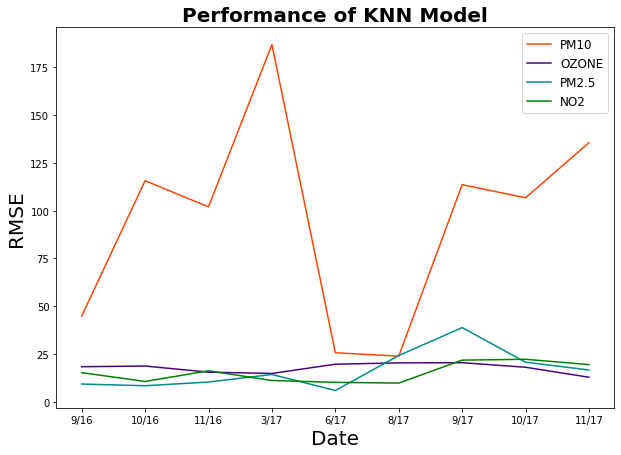

In [61]:
#Plot RMSEs
fig, ax = plt.subplots(figsize = (10, 7))
plt.title('Performance of KNN Model', size = 20, fontweight = 'bold')
plt.ylabel('RMSE', size = 20)
plt.xlabel('Date', size = 20)
ax.plot(np.arange(1,10), abs(RMSE_array[0, :]), label = 'PM10', color = 'orangered')
ax.plot(np.arange(1,10), abs(RMSE_array[1,:]), label = 'OZONE', color = 'indigo')
ax.plot(np.arange(1,10), abs(RMSE_array[2,:]), label = 'PM2.5', color = 'darkcyan')
ax.plot(np.arange(1,10), abs(RMSE_array[3,:]), label = 'NO2', color = 'green')
ax.set_xticklabels([0, '9/16', '10/16', '11/16', '3/17', '6/17', '8/17', '9/17', '10/17', '11/17'])
plt.legend(fontsize = 'large')

While our Ozone, NO2, and PM2.5 model seemed to perform within a consistent range, our PM10 model performance varied widely! This is likely because PM10 settles quickly compared to PM2.5, leading to wider variation in measurements. 

Since our air quality measures are in different units, we'll separate our parameters by those that are measured in the same units to better understand the RMSE: PM2.5 & PM10 (ug/m3) and NO2 and Ozone (ppb).

<ipython-input-65-27485e638639>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([0, '9/16', '10/16', '11/16', '3/17', '6/17', '8/17', '9/17', '10/17', '11/17'])
<ipython-input-65-27485e638639>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([0, '9/16', '10/16', '11/16', '3/17', '6/17', '8/17', '9/17', '10/17', '11/17'])


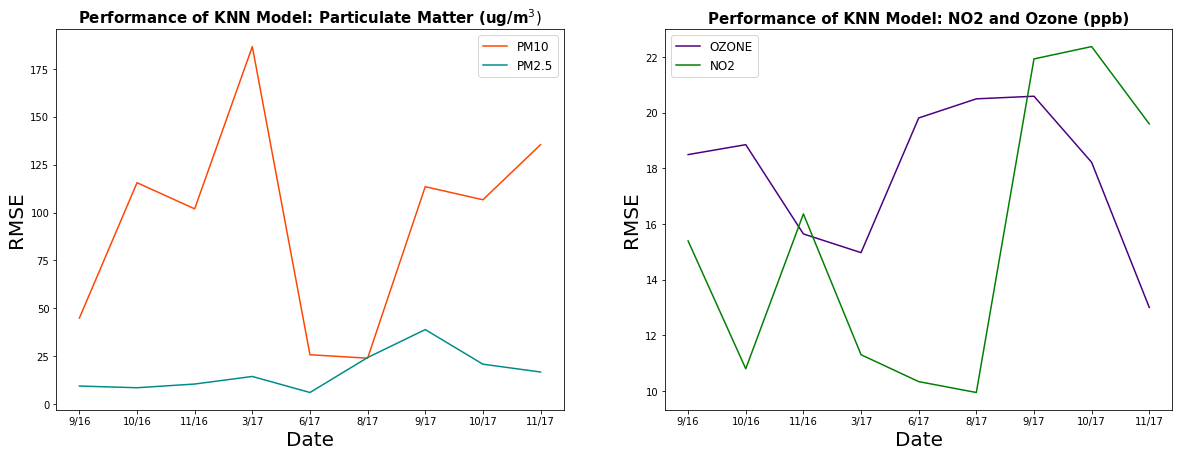

In [65]:
#Plot RMSEs
fig, ax = plt.subplots(ncols = 2, figsize = (20, 7))
ax[0].set_title('Performance of KNN Model: Particulate Matter (ug/m$^{3})$', size = 15, fontweight = 'bold')
ax[0].set_ylabel('RMSE', size = 20)
ax[0].set_xlabel('Date', size = 20)
ax[0].plot(np.arange(1,10), abs(RMSE_array[0, :]), label = 'PM10', color = 'orangered')
ax[0].plot(np.arange(1,10), abs(RMSE_array[2,:]), label = 'PM2.5', color = 'darkcyan')
ax[0].set_xticklabels([0, '9/16', '10/16', '11/16', '3/17', '6/17', '8/17', '9/17', '10/17', '11/17'])
ax[0].legend(fontsize = 'large')

ax[1].set_title('Performance of KNN Model: NO2 and Ozone (ppb)', size = 15, fontweight = 'bold')
ax[1].set_ylabel('RMSE', size = 20)
ax[1].set_xlabel('Date', size = 20)
ax[1].plot(np.arange(1,10), abs(RMSE_array[1,:]), label = 'OZONE', color = 'indigo')
ax[1].plot(np.arange(1,10), abs(RMSE_array[3,:]), label = 'NO2', color = 'green')
ax[1].set_xticklabels([0, '9/16', '10/16', '11/16', '3/17', '6/17', '8/17', '9/17', '10/17', '11/17'])
ax[1].legend(fontsize = 'large')
plt.savefig('Data/KNN_byunit.png')

From this graph, we can better disaggregate the performances of our various models. 

Let's also see how our model performs if we don't subset by time, but do subset by air quality parameter. 

In [86]:
#Define a function to train the model and find the optimal hyperparameters. 

def KNN_param(df, parameter, k):
    """Fits a KNN model for a specific air quality parameter. 
    Arguments:
        dataframe: the Air Now dataframe. 
        parameter (string): Air quality measurement parameter: PM10, OZONE, PM2.5, CO, NO2, SO2
        k: an array of k values to test for fitting model
    Returns:
        model: the trained model
        opt_k: the optimal k value
        opt_score: the mean MSE of the optimal k value
        """
    
    #Filter data to parameter
    data = df[df['Parameter'] == parameter]
    lat = data.geometry.y
    lon  = data.geometry.x
    X = pd.DataFrame({'lat': lat, 'lon': lon})
    y = data['Value_mean']
    
    #knn model object
    knn = KNeighborsRegressor()
    
    #create dictionary of parameter values
    param_grid = {'n_neighbors': k, 'weights': ['uniform', 'distance']}
    
    #specify hyperparameters
    knn_cv = GridSearchCV(knn, param_grid, scoring = 'neg_root_mean_squared_error', cv = 10)
    
    #fit model
    model = knn_cv.fit(X,y)
    
    return model, model.best_params_, model.best_score_

In [87]:
#Run through loop for to fit model for each parameter 
parameters_2 = np.array(['PM10', 'OZONE', 'PM2.5','NO2', 'CO','SO2']) #Return SO2 & CO
for i in range(len(parameters_2)):
    _, params, RMSE = KNN_param(airnow, parameters_2[i], np.arange(1, 11))
    print(str(parameters_2[i]) + ' parameters:', params)
    print(str(parameters_2[i]) + ' RMSE:', RMSE)  

PM10 parameters: {'n_neighbors': 10, 'weights': 'uniform'}
PM10 RMSE: -142.9438988532488
OZONE parameters: {'n_neighbors': 10, 'weights': 'uniform'}
OZONE RMSE: -25.990251597365805
PM2.5 parameters: {'n_neighbors': 9, 'weights': 'uniform'}
PM2.5 RMSE: -21.784386795952454
NO2 parameters: {'n_neighbors': 10, 'weights': 'uniform'}
NO2 RMSE: -20.085822237127946
CO parameters: {'n_neighbors': 10, 'weights': 'distance'}
CO RMSE: -0.1972710641912063
SO2 parameters: {'n_neighbors': 1, 'weights': 'uniform'}
SO2 RMSE: -12.321879922002108


Now, that we've taken a look at how the model performs, we'll create a function to use the fitted optimal model for any given month/year/parameter to predict that air quality parameter value for the corresponding month/year of each observation in our dataset, using the latitudes and longitudes of the emitter points. We'll append this prediction as a column with the predicted values. 

In [66]:
def predict_AQ(airnow, emitter, parameter, dates, k):
    """Fits a KNN model for a specific air quality parameter averaged over a given month, in a given year. 
    Uses that model to predict the air quality measure at the emitter point location in that month and year 
    and appends the prediction to the dataframe.
    Arguments:
        airnow: the Air Now dataframe. 
        emitter: the methane emitter dataframe
        parameter: an nd.array of air quality measurement parameters: PM10, OZONE, PM2.5, NO2
        dates: an 2darray of the month/year combos to fit; the year/month combos that appear in the emitter dataset.
            Should follow format [month (1-12), year (2016 or 2017)]
        k: an array of k values to test for fitting model
    Returns:
        model: the trained model
        opt_k: the optimal k value
        opt_score: the mean MSE of the optimal k value
        """
    
    #add column to store predicted air quality measure
    for z in range(len(parameter)):
        emitter[parameter[z]] = 0
    
        #Fit model & get prediction for every year/month combo 
        for i in range(len(dates)): 
            #fit the model for each month/date combo in dates
            model, _, _ = KNN(airnow, parameter[z], dates[i, 1], dates[i, 0], np.arange(1, 11)) 
            #For any corresponding observations with that same date/month combo, predict the air quality value and append
            for j in range(len(emitter)):
                if (emitter['aviris_month'][j] == dates[i,0]) & (emitter['aviris_year'][j] == dates[i,1]):
                    X = np.array([emitter['geometry'][j].centroid.y, emitter['geometry'][j].centroid.x]).reshape(1,-1)
                    y_pred = model.predict(X)
                    emitter.loc[j, parameter[z]] = y_pred
    
    return emitter

In [69]:
#Now, we can predict for PM10, Ozone, PM2.5, and NO2
predictions = predict_AQ(airnow, ch4, parameters, dates, np.arange(1,11))

In [70]:
predictions.head()

,Vista_ID,AVIRIS_CH4_median_ppmm,AVIRIS_CH4_median_date,AVIRIS_CH4_pxcount,CH4_Mass_kg,ng_pipelength_2,ng_pipelength_1000,ng_pipelength_5000,ng_pipelength_10000,ng_pipelength_50000,...,aviris_month,tropomi_no2_mean,tropomi_o3_mean,tropomi_so2_mean,geometry,PM10,aviris_year,OZONE,PM2.5,NO2
0,DAF001852,152.0039,2016-09-11,835.7500,0.0001,6392.1007,7391.6466,16539.2553,57707.9384,667538.8408,...,9,0.0,2.7501,0.3199,"MULTIPOLYGON (((-82488.739 -16790.579, -82489....",51.7243771960,2016,54.5756497435,12.1100081377,12.3527753832
1,DAF001876,111.8814,2016-09-12,1670.0000,0.0001,85884.6586,94127.2287,127492.1839,170899.8068,842878.1810,...,9,0.0,2.7094,0.4187,"MULTIPOLYGON (((260247.391 -342212.585, 260246...",123.7548698424,2016,54.6354415671,12.0162907594,17.4469380755
2,DAF001759,244.1223,2016-09-12,3346.0000,0.0002,18873.8279,21161.2918,29954.3051,43939.1783,334243.8826,...,9,0.0,2.6972,0.3413,"MULTIPOLYGON (((61647.033 -234595.348, 61646.1...",122.0858984460,2016,58.8677224619,12.2105853674,17.8956749846
3,DAF001767,112.7884,2016-09-12,1114.6667,0.0001,0.0000,0.0000,0.0000,6753.5702,336951.9840,...,9,0.0,2.6981,0.3361,"MULTIPOLYGON (((45304.763 -224578.476, 45303.9...",101.7198903007,2016,54.9329847097,13.7132122547,23.5387321492
4,DAF001776,105.4107,2016-09-12,1216.2727,0.0001,0.0000,0.0000,0.0000,0.0000,264800.5901,...,9,0.0,2.7004,0.3429,"MULTIPOLYGON (((39551.942 -203816.734, 39551.1...",101.7198903007,2016,54.9329847097,13.7132122547,23.3134271682


In [156]:
#predictions.to_file('target_and_features_AQ.geojson', driver = 'GeoJSON')

To see our predictions, we'll plot a histogram of each parameter. 

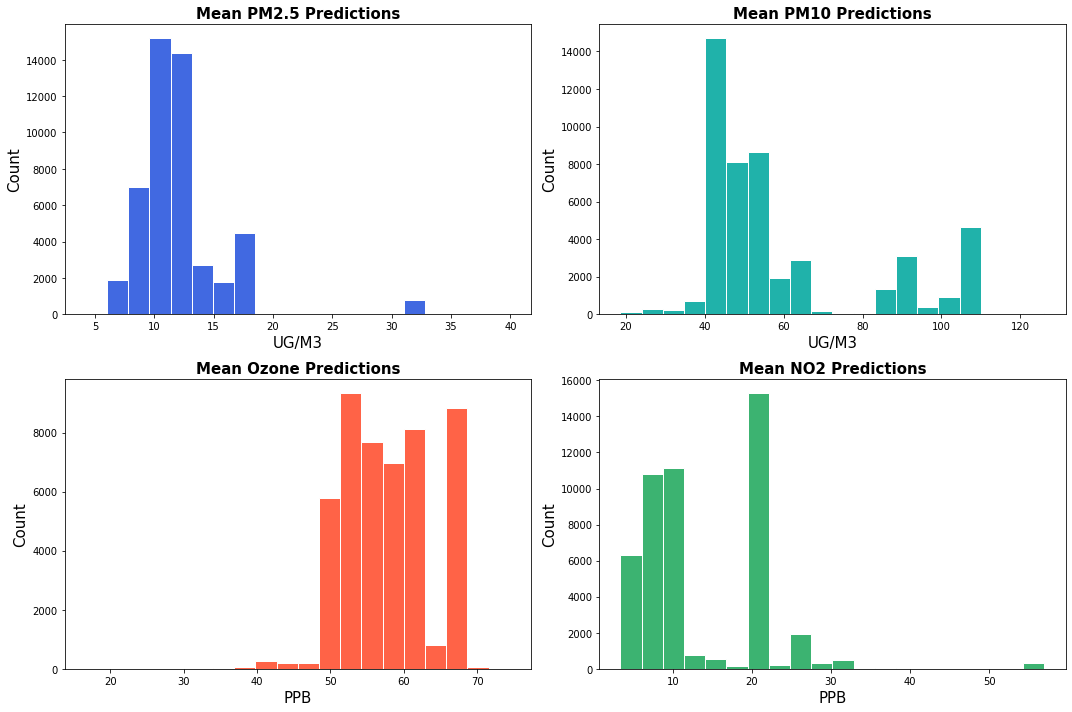

In [71]:
#Plot predicted values
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (15, 10))
ax[0,0].hist(predictions['PM2.5'], edgecolor = 'white', color = 'royalblue', bins = 20)
ax[0,0].set_xlabel('UG/M3', size = 15)
ax[0,0].set_ylabel('Count', size = 15)
ax[0,0].set_title('Mean PM2.5 Predictions', fontweight = 'bold', size = 15)

ax[0,1].hist(predictions['PM10'], edgecolor = 'white', color = 'lightseagreen', bins = 20)
ax[0,1].set_xlabel('UG/M3', size = 15)
ax[0,1].set_ylabel('Count', size = 15)
ax[0,1].set_title('Mean PM10 Predictions', fontweight = 'bold', size = 15)

ax[1,0].hist(predictions['OZONE'], edgecolor = 'white', color = 'tomato', bins = 20)
ax[1,0].set_xlabel('PPB', size = 15)
ax[1,0].set_ylabel('Count', size = 15)
ax[1,0].set_title('Mean Ozone Predictions', fontweight = 'bold', size = 15)

ax[1,1].hist(predictions['NO2'], edgecolor = 'white', color = 'mediumseagreen', bins = 20)
ax[1,1].set_xlabel('PPB', size = 15)
ax[1,1].set_ylabel('Count', size = 15)
ax[1,1].set_title('Mean NO2 Predictions', fontweight = 'bold', size = 15)
plt.tight_layout()
#plt.savefig('Data/AQ_Predictions.png')

We can also see how these histograms compare with the AirNow values. 

In [81]:
#Filter AirNow for months that we used in our models
plot = airnow[(airnow['month'] == 3) | (airnow['month'] == 6) | 
       (airnow['month'] == 9) | (airnow['month'] == 10) | 
      (airnow['month'] == 11) | (airnow['month'] == 8)]

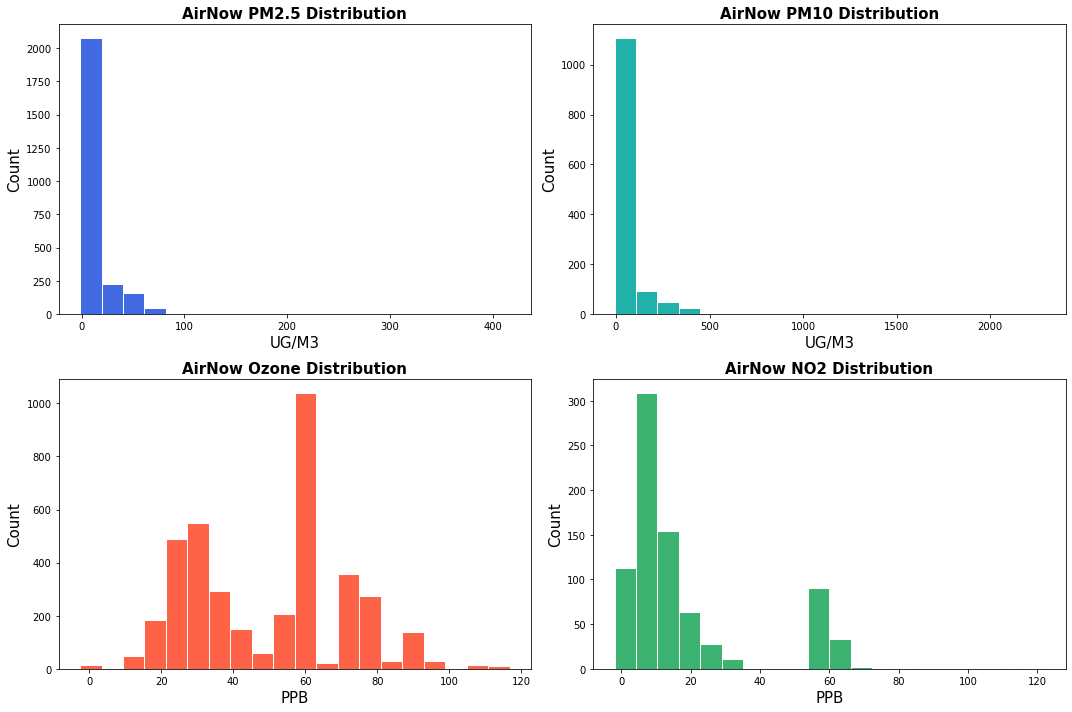

In [106]:
#Plot AirNow distribution
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (15, 10))
ax[0,0].hist(plot[plot['Parameter'] == 'PM2.5']['Value_mean'], edgecolor = 'white', color = 'royalblue', bins = 20)
ax[0,0].set_xlabel('UG/M3', size = 15)
ax[0,0].set_ylabel('Count', size = 15)
ax[0,0].set_title('AirNow PM2.5 Distribution', fontweight = 'bold', size = 15)

ax[0,1].hist(plot[plot['Parameter'] == 'PM10']['Value_mean'], edgecolor = 'white', color = 'lightseagreen', bins = 20)
ax[0,1].set_xlabel('UG/M3', size = 15)
ax[0,1].set_ylabel('Count', size = 15)
ax[0,1].set_title('AirNow PM10 Distribution', fontweight = 'bold', size = 15)

ax[1,0].hist(plot[plot['Parameter'] == 'OZONE']['Value_mean'], edgecolor = 'white', color = 'tomato', bins = 20)
ax[1,0].set_xlabel('PPB', size = 15)
ax[1,0].set_ylabel('Count', size = 15)
ax[1,0].set_title('AirNow Ozone Distribution', fontweight = 'bold', size = 15)

ax[1,1].hist(plot[plot['Parameter'] == 'NO2']['Value_mean'], edgecolor = 'white', color = 'mediumseagreen', bins = 20)
ax[1,1].set_xlabel('PPB', size = 15)
ax[1,1].set_ylabel('Count', size = 15)
ax[1,1].set_title('AirNow NO2 Distribution', fontweight = 'bold', size = 15)
plt.tight_layout()

Fiinaly, we're also interested in seeing how the Ozone and NO2 measures correlate with our Tropomi measures. 

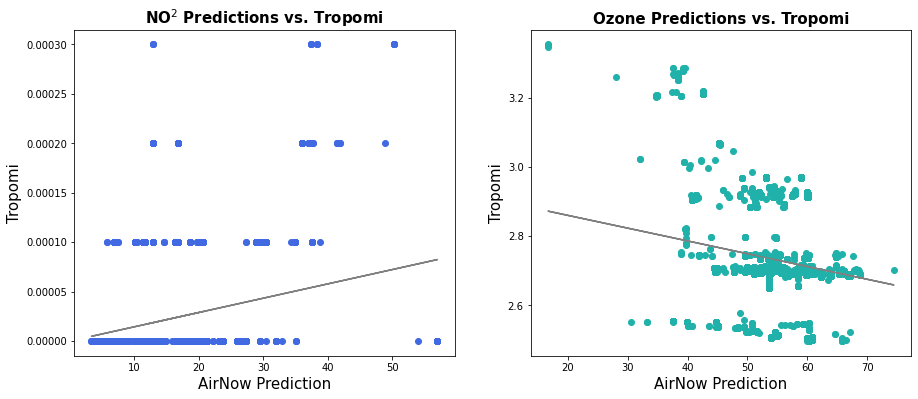

In [105]:
#Plot AirNow predictions vs. Tropomi
fig, ax = plt.subplots(ncols = 2, figsize = (15, 6))
ax[0].scatter(predictions['NO2'], predictions['tropomi_no2_mean'], color = 'royalblue')
ax[0].set_xlabel('AirNow Prediction', size = 15)
ax[0].set_ylabel('Tropomi', size = 15)
ax[0].set_title('NO$^{2}$ Predictions vs. Tropomi', fontweight = 'bold', size = 15)
z = np.polyfit(predictions['NO2'], predictions['tropomi_no2_mean'], 1)
p = np.poly1d(z)
ax[0].plot(predictions['NO2'], p(predictions['NO2']), color = 'gray')

ax[1].scatter(predictions['OZONE'], predictions['tropomi_o3_mean'], color = 'lightseagreen')
ax[1].set_xlabel('AirNow Prediction', size = 15)
ax[1].set_ylabel('Tropomi', size = 15)
ax[1].set_title('Ozone Predictions vs. Tropomi', fontweight = 'bold', size = 15)
z = np.polyfit(predictions['OZONE'], predictions['tropomi_o3_mean'], 1)
p = np.poly1d(z)
ax[1].plot(predictions['OZONE'], p(predictions['OZONE']), color = 'gray')
#plt.savefig('Data/AirNow_tropomi.png')

There seems to be a very slight positive correlation between Tropomi mol/m2 and AirNow prediction ppb, which is what we would expect to see. The negatve correlation between Tropomi Ozone measurements and the AirNow prediction is surprising. 

In [175]:
#Compare with airnow to ensure range of values seems reasonable
airnow[(airnow['Parameter'] == 'NO2') & (airnow['month'] == 11) & (airnow['year'] == 2017)]

,Latitude,Longitude,Parameter,Unit,Category,SiteName,AgencyName,FullAQSCod,IntlAQSCod,year,month,Value_mean,Value_coun,RawConcent,RawConce_1,AQI_mean,AQI_count,geometry
102,32.791700,-115.561700,NO2,PPB,1,El Centro - 9th Street,Imperial County Air Pollution Control District,060251003,840060251003,2017,11,9.310294,1360,9.776176,1360,8.872059,1360,POINT (416149.028 -570353.757)
1162,33.676535,-117.331027,NO2,PPB,1,Lake Elsinore - W. Flint Street,South Coast AQMD,60659001,840060659001,2017,11,12.920228,1404,13.362678,1404,12.205128,1404,POINT (247549.665 -478555.246)
1503,33.819305,-117.918759,NO2,PPB,1,Anaheim Near Road,South Coast AQMD,60590008,840060590008,2017,11,27.110778,1336,27.565868,1336,25.564371,1336,POINT (192699.470 -464092.900)
1510,33.819305,-117.918759,NO2,PPB,2,Anaheim Near Road,South Coast AQMD,60590008,840060590008,2017,11,63.935484,62,64.390323,62,61.483871,62,POINT (192699.470 -464092.900)
1535,33.830586,-117.938509,NO2,PPB,1,Anaheim,South Coast AQMD,60590007,840060590007,2017,11,23.543575,1354,24.008991,1354,22.221566,1354,POINT (190843.931 -462882.080)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14903,38.712090,-121.381090,NO2,PPB,2,Antelope - North Highlands,Sacramento Metro. AQMD,60670002,840060670002,2017,11,70.000000,6,70.000000,6,68.000000,6,POINT (-119961.483 78211.963)
15024,38.746430,-121.264980,NO2,PPB,1,Roseville - N.Sunrise/Douglas,California Air Resources Board,60610006,840060610006,2017,11,8.540862,1346,9.005646,1346,8.133730,1346,POINT (-109825.867 81887.922)
15579,39.138680,-121.618840,NO2,PPB,1,Yuba City,California Air Resources Board,061010003,840061010003,2017,11,7.197037,1350,7.654963,1350,6.900741,1350,POINT (-139801.036 125946.167)
16497,39.761680,-121.840470,NO2,PPB,1,Chico - East,California Air Resources Board,060070008,840060070008,2017,11,6.422680,1358,6.882327,1358,6.170839,1358,POINT (-157594.638 195511.828)


If we want AQI Values, we can use the function below. 

In [113]:
#For AQI, note NAN observations need to be removed beforehand, since scikitlearn gives an error with NAN

def KNN_AQI(df, year, month, k):
    """Fits a KNN model for AQI, averaged over a given month, in a given year. 
    Arguments:
        dataframe: the Air Now dataframe. 
        year: year to use to fit model, 2016 or 2017
        month: month to use to fit model (1-12)
        k: an array of k values to test for fitting model
    Returns:
        model: the trained model
        opt_k: the optimal k value
        opt_score: the mean MSE of the optimal k value
        """
    
    #Filter data to month, year, and parameter
    data = df[(df['year'] == year) & (df['month'] == month)]
    X = data.iloc[:, 0:2].copy()
    y = data['AQI_mean']
    
    #knn model object
    knn = KNeighborsRegressor()
    
    #create dictionary of parameter values
    param_grid = {'n_neighbors': k, 'weights': ['uniform', 'distance']}
    
    #specifu hyperparameters
    knn_cv = GridSearchCV(knn, param_grid, scoring = 'neg_root_mean_squared_error', cv = 10)
    
    #fit model
    model = knn_cv.fit(X,y)
    
    return model, model.best_params_, model.best_score_